# Lesson 8: Time Series Forecasting

Please keep the TensorFlow version of this notebook as a reference: https://github.com/sambitmukherjee/handson-ml3/blob/main/bonus/udacity/Intro_to_TF_for_DL/Lesson_8_A.ipynb

## I. Introduction

## II. Applications

## III. Common Patterns

## IV. Colab: Common Patterns

### Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def plot_series(time, series, format='-', start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel('Time')
    plt.ylabel('Value')
    if label is not None:
        plt.legend(fontsize=14)
    plt.grid(True)

### Trend and Seasonality

In [3]:
def trend(time, slope=0):
    return slope * time

In [4]:
time = np.arange(4 * 365 + 1) # 1 is added since every four years there is a leap year.
time

array([   0,    1,    2, ..., 1458, 1459, 1460])

In [5]:
baseline = 10
series = baseline + trend(time, 0.1)
series

array([ 10. ,  10.1,  10.2, ..., 155.8, 155.9, 156. ])

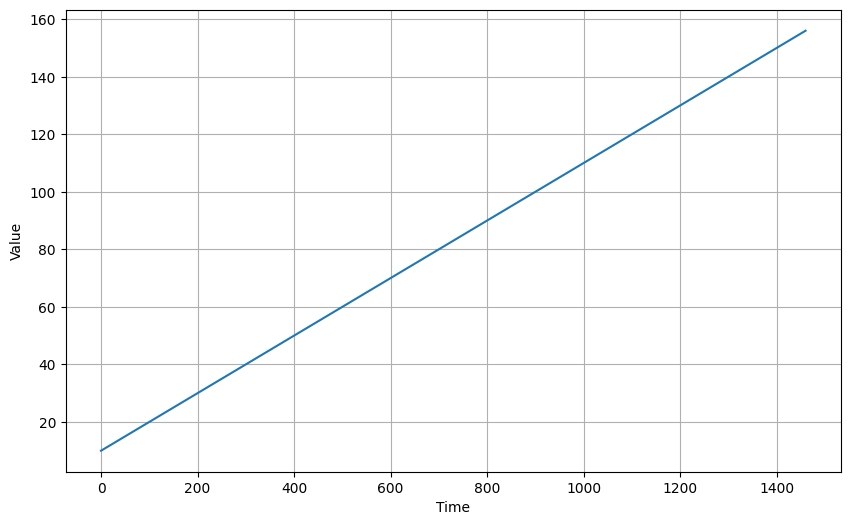

In [6]:
plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

In [7]:
# Just run:
def seasonal_pattern(season_time):
    """Just an arbitrary pattern; you can change it if you wish."""
    return np.where(season_time < 0.4, np.cos(season_time * 2 * np.pi), 1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern in each period."""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

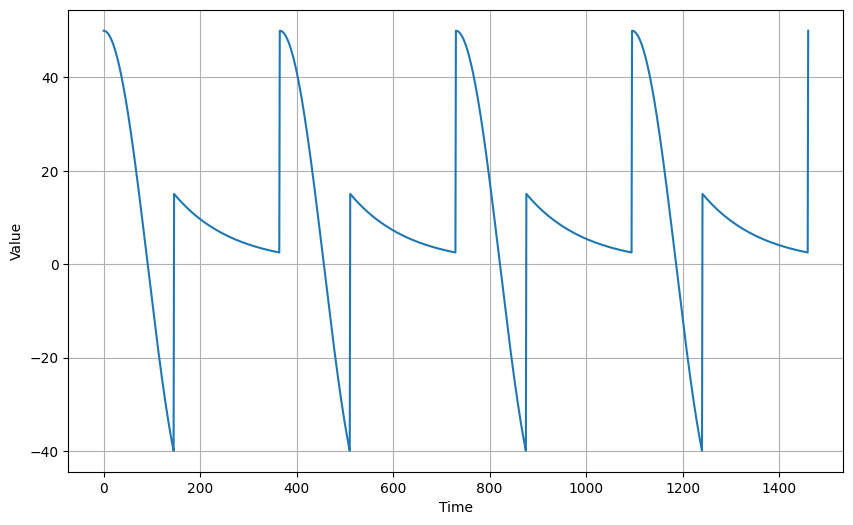

In [8]:
amplitude = 50
series = seasonality(time, period=365, amplitude=amplitude)

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

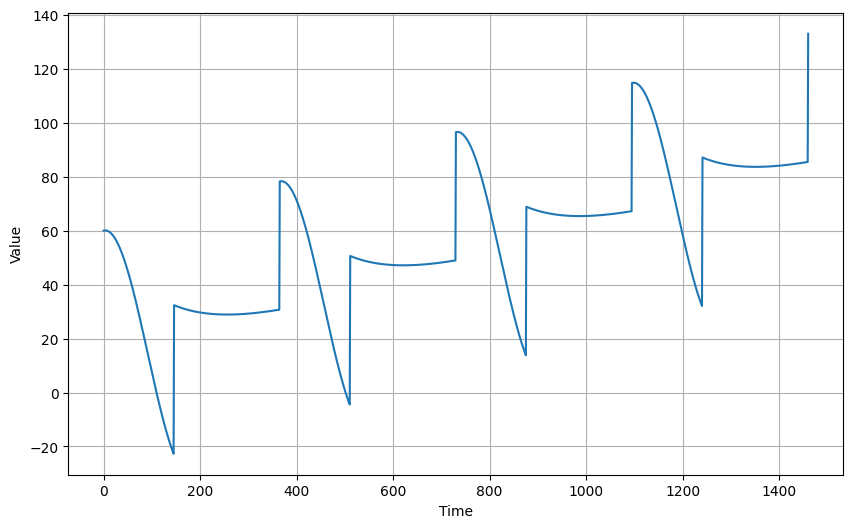

In [9]:
slope = 0.05
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

### Noise

In [10]:
def white_noise(time, noise_level=1, seed=None):
    return np.random.RandomState(seed).randn(len(time)) * noise_level

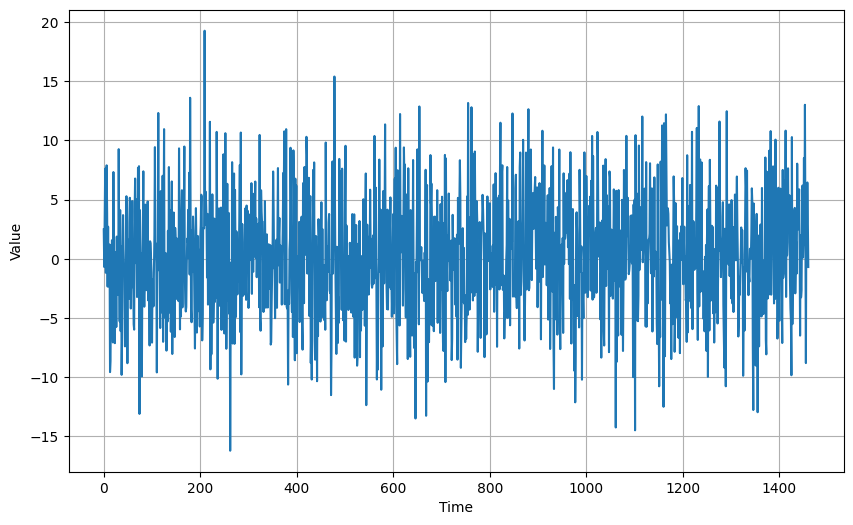

In [11]:
noise_level = 5
noise = white_noise(time, noise_level, seed=42)

plt.figure(figsize=(10, 6))
plot_series(time, noise)
plt.show()

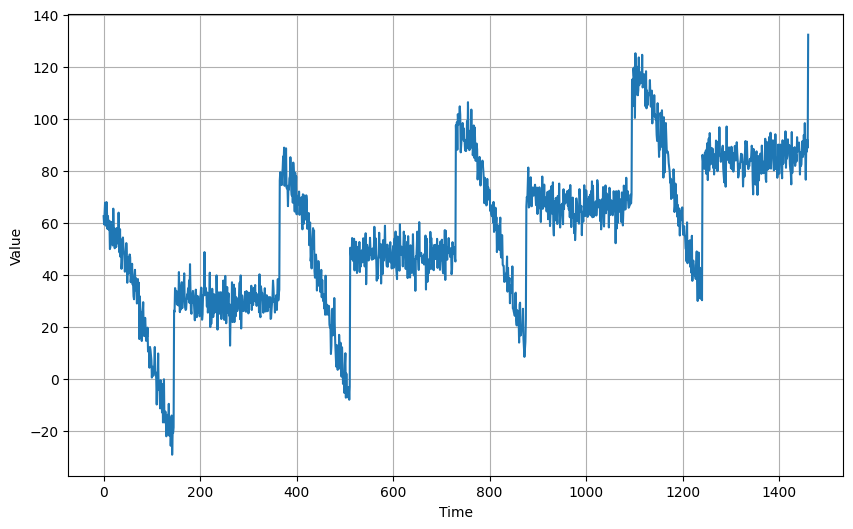

In [12]:
series += noise

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

We shall call this the 'Geron Synthetic Time Series' (named after Aurelien Geron).